# NLP Project - neural-bridge/rag-dataset-12000 dataset

*Team members*:
- Asja Attanasio
- Daniele Laganà
- Marcello Martini
- Gianluigi Palmisano

# ⬆️ Dataset import and library setup

In this section, we import all the necessary Python libraries to support data loading, preprocessing, analysis, and visualization. 

The functionalities of the imported libraries include:
- **Data manipulation**: `pandas`, `numpy`, `collections.Counter`
- **Text processing and analysis**: `nltk` for tokenization, stopword removal, and frequency distribution
- **Data visualization**: `matplotlib.pyplot` and `seaborn` for plotting and visual exploration
- **Transformer models and training**: `transformers` for loading pretrained tokenizers and models, and for training with `Trainer` and `TrainingArguments`
- **Dataset management**: `datasets` from Hugging Face for loading and working with NLP datasets
- **Utility tools**: `tqdm` for progress bars, `re` for regular expressions, and `torch` for PyTorch operations
- **Interactive table display**: `itables` to enable interactive views of `pandas` DataFrames in the notebook

We then load the dataset from the Hugging Face Hub: [neural-bridge/rag-dataset-12000](https://huggingface.co/datasets/neural-bridge/rag-dataset-12000). 

Each sample consists of:
- `context`: a passage containing the information needed to answer the question
- `question`: a natural language question related to the context
- `answer`: a response automatically generated by GPT-4

The dataset is already divided in two sets:
- **Train set**: 9,600 samples
- **Test set**: 2,400 samples

In [29]:
import os

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# Check if running in Kaggle
IN_KAGGLE = 'KAGGLE_KERNEL_RUN_TYPE' in os.environ

if IN_KAGGLE:
  os.environ["TOKENIZERS_PARALLELISM"] = "false"
  from plotly.offline import init_notebook_mode
  init_notebook_mode(connected=True)

if IN_COLAB:
  !pip install datasets gensim datamapplot


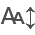

In [30]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm import tqdm
import pandas as pd
from datasets import load_dataset
import itables
import re
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from datasets import Dataset, DatasetDict
import numpy as np
import torch

# For interactive tables
itables.init_notebook_mode(all_interactive=False)



In [31]:
# Import dataset using the Hugging Face datasets library
dataset = load_dataset("neural-bridge/rag-dataset-12000")

In [32]:
dataset

DatasetDict({
    train: Dataset({
        features: ['context', 'question', 'answer'],
        num_rows: 9600
    })
    test: Dataset({
        features: ['context', 'question', 'answer'],
        num_rows: 2400
    })
})

In [33]:
train_df = dataset['train'].to_pandas()
test_df = dataset['test'].to_pandas()

In [34]:
train_df.head()

context  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         Caption: Tasmanian berry grower Nic Hansen showing Macau chef Antimo Merone around his property as part of export engagement activities.\nTHE RISE and rise of the Australian strawberry, raspberry and blackberry industries has seen the sectors redouble their international trade focus, with the release of a dedicated export plan to grow their global presence over the next 10 years.\nDriven by significant grower input, the Berry Export Summary 2028 maps the sectors’ current position, where they want to be, high-opportunity markets and next steps.\nHort Innovation trade manager Jenny Van de Meeberg said the value and volume of raspberry and blackberry exports rose by 100 per cent between 2016 and 2017. She said the Australian strawberry industry experienced similar success with an almost 30 per cent rise in export volume and a 26 per cent rise in value to $32.6M over the same period.\n“Australian berry sectors are in a firm position at the moment,” she said. “Production, adoption of protected substrate cropping, improved genetics and an expanding geographic footprint have all helped put Aussie berries on a positive tr

In [35]:
print("Train set size:", len(train_df))
print("Test set size:", len(test_df))
print("Columns:", train_df.columns)

Train set size: 9600
Test set size: 2400
Columns: Index(['context', 'question', 'answer'], dtype='object')


# 🔎 Data exploration

In this section, we perform an initial exploration of the dataset to better understand its structure, content, and quality. The main objectives of this phase are to clean the data, analyze basic textual properties, and identify key patterns that may inform later modeling decisions.

We begin by identifying and removing rows with missing values in the `context`, `question`, or `answer` fields. Texts are then preprocessed using NLTK: tokenized, lowercased, stripped of punctuation, and filtered for stopwords.

We compute token length statistics for `context` and `question` fields and build a vocabulary from the training set, then calculate the frequency distribution of all tokens in the training data and visualize it.

Finally, we analyze the frequency of interrogative words (`what`, `where`, `when`, `who`, `why`, `how`, `which`) in the questions to gain insight into their nature.

In [36]:
# Count rows with at least one missing value in 'context', 'question', or 'answer'
missing_rows_train = train_df[['context', 'question', 'answer']].isnull().any(axis=1).sum()
missing_rows_test = test_df[['context', 'question', 'answer']].isnull().any(axis=1).sum()

print("Rows with at least one missing value in train set:", missing_rows_train)
print("Rows with at least one missing value in test set:", missing_rows_test)

# Remove null values
train_df = train_df.dropna()
test_df = test_df.dropna()

Rows with at least one missing value in train set: 2
Rows with at least one missing value in test set: 1


In [37]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

# Initialize stopwords
stop_words = set(stopwords.words('english'))

# Initialize lists and variables for analysis
context_lengths = []
question_lengths = []
vocab = set()

# Initialize lists for all tokens
all_tokens = []
train_df_tokenized = []

# Function to preprocess text
def preprocess(text):
    """Tokenize, lowercase, remove punctuation and stopwords from text."""
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalnum()]  # Keep only alphanumeric tokens
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return tokens

# Function to process a single entry
def process_entry(entry):
    """Process a single dataset entry to extract tokens and update statistics."""
    context_tokens = preprocess(entry['context'])
    question_tokens = preprocess(entry['question'])

    # Update lengths
    context_lengths.append(len(context_tokens))
    question_lengths.append(len(question_tokens))
    answer_tokens = preprocess(entry['answer'])

    # Update vocabulary and token list
    vocab.update(context_tokens)
    vocab.update(question_tokens)
    all_tokens.extend(context_tokens)
    all_tokens.extend(question_tokens)
    train_df_tokenized.append({'context': context_tokens, 'question': question_tokens, 'answer': answer_tokens})

tqdm.pandas(desc="Processing entries")
train_df.progress_apply(process_entry, axis=1)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/martinimarcello00/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/martinimarcello00/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/martinimarcello00/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
Processing entries: 100%|██████████| 9598/9598 [00:22<00:00, 431.28it/s]


0       None
1       None
2       None
3       None
4       None
        ... 
9595    None
9596    None
9597    None
9598    None
9599    None
Length: 9598, dtype: object

In [38]:
# Compute the frequency distribution of tokens
fdist = FreqDist(all_tokens)
fdist

FreqDist({'one': 14432, 'also': 10326, 'new': 10136, 'time': 10131, 'like': 9989, 'would': 8828, 'get': 8782, 'said': 7855, 'people': 7767, 'first': 6947, ...})

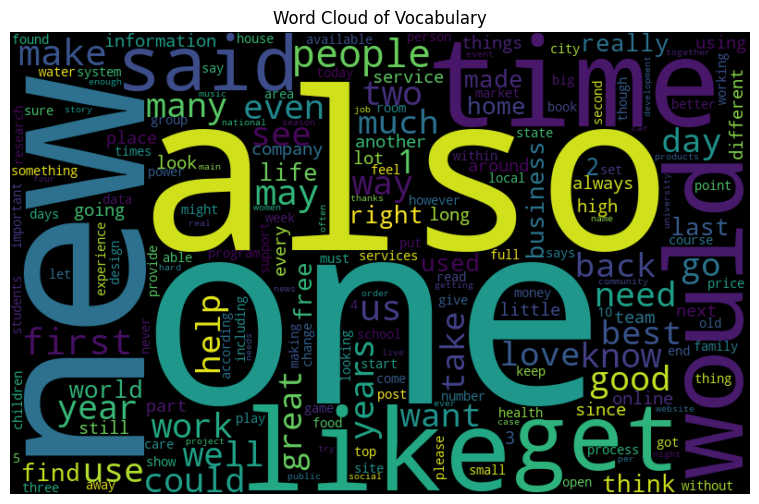

In [39]:
from wordcloud import WordCloud

# Plot the word cloud
wordcloud = WordCloud(width=800, height=500).generate_from_frequencies(fdist)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Vocabulary")
plt.show()

The word cloud confirms that the dataset is well-suited for training models on general-domain retrieval-based QA. The shared vocabulary between context and question tokens implies:

- Strong lexical overlap between what is asked and what is retrieved,

- Good support for tasks requiring semantic matching and answer extraction,

- A balanced mix of common factual knowledge, reasoning, and information-seeking behavior.

<Axes: title={'center': 'Top 30 Most Frequent Words'}, xlabel='Samples', ylabel='Counts'>

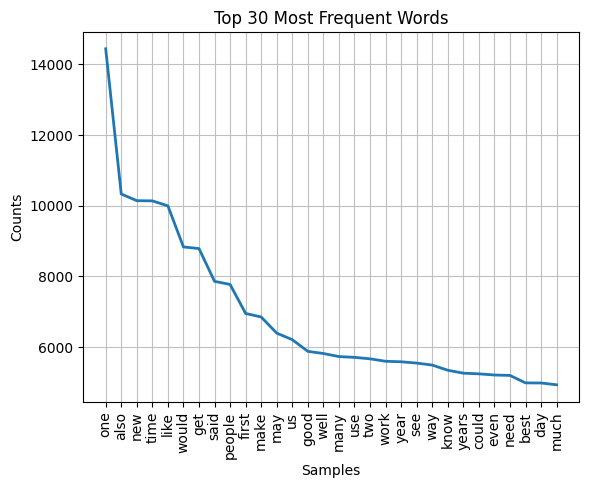

In [40]:
# Plot the frequency distribution of the most common words
fdist.plot(30,  title="Top 30 Most Frequent Words")

This frequency plot quantitatively supports the earlier word cloud insights by highlighting the most dominant tokens in the combined context and question texts.

In [41]:
# Print statistics
print(f"Number of documents: {len(train_df)}")
print(f"Average context length: {sum(context_lengths)/len(context_lengths):.2f} tokens")
print(f"Average question length: {sum(question_lengths)/len(question_lengths):.2f} tokens")
print(f"Vocabulary size: {len(vocab)}")

Number of documents: 9598
Average context length: 321.12 tokens
Average question length: 6.81 tokens
Vocabulary size: 128313


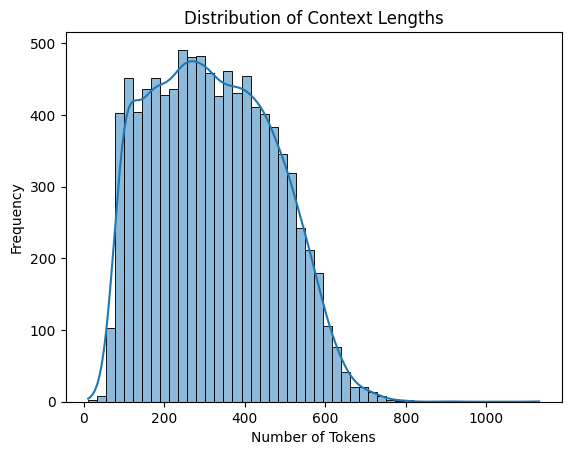

In [42]:
# Plot distribution of context lengths
sns.histplot(context_lengths, bins=50, kde=True)
plt.title('Distribution of Context Lengths')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()

Most contexts fall between 200 and 450 tokens, peaking around 300–350 tokens. This suggests that the dataset emphasizes substantial, information-rich contexts, making it well-suited for tasks like retrieval-augmented generation.

The distribution is right-skewed, with fewer very long contexts (up to 1000+ tokens), but they are still meaningfully present. In fact, even if such long contexts make up a small percentage of the dataset, they can be important for training robustness.
This indicates a diversity of passage lengths, likely sourced from a variety of materials, from short summaries to full paragraphs.

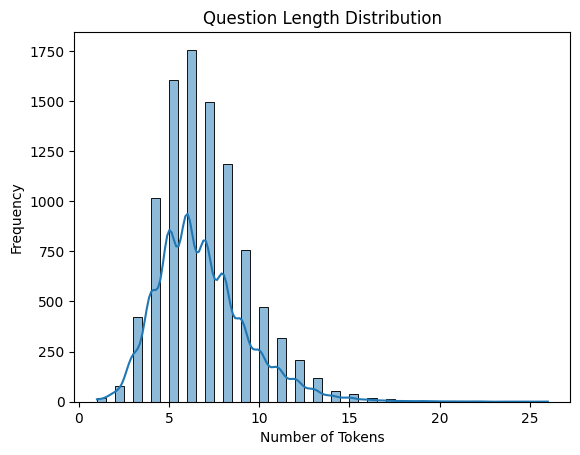

In [43]:
sns.histplot(question_lengths, bins=50, kde=True)
plt.title("Question Length Distribution")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.show()

We see that the questions in this dataset tend to be quite concise. The histogram peaks sharply around 6 tokens, indicating that this is the most common question length. In fact, the majority of the dataset appears to be concentrated between 4 and 10 tokens, suggesting that the dataset favors short, focused queries.

In [44]:
# Compute the distribttion of the question words
question_words = ["what", "where", "when", "why", "how", "who", "which"]
question_word_counts = {word: 0 for word in question_words}
for question in train_df['question']:
    tokens = word_tokenize(question.lower())
    for word in question_words:
        question_word_counts[word] += tokens.count(word)

In [45]:
question_word_counts_df = pd.DataFrame(list(question_word_counts.items()), columns=['Question Word', 'Count'])
question_word_counts_df = question_word_counts_df.sort_values(by='Count', ascending=False)
question_word_counts_df

,Question Word,Count
0,what,7490
5,who,1673
4,how,429
2,when,400
3,why,275
1,where,161
6,which,87


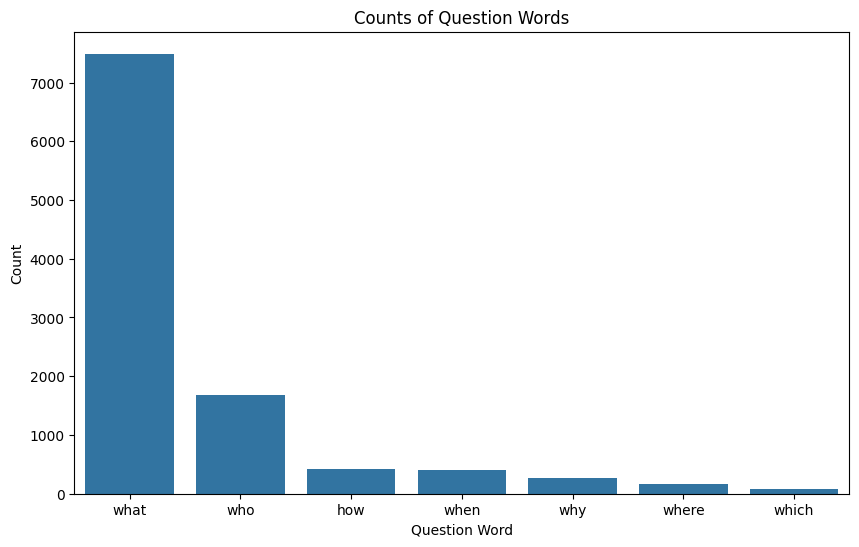

In [46]:
# Plotting the counts of question words
plt.figure(figsize=(10, 6))
sns.barplot(x='Question Word', y='Count', data=question_word_counts_df)
plt.title('Counts of Question Words')
plt.ylabel('Count')
plt.show()

We counted the question words to better understand the types of questions present in the dataset. The plot shows a strong predominance of "what" questions, indicating the dataset is heavily skewed toward fact-based queries, while other question types like "who," "how," and "why" are much less frequent.

# 🧹 Data Cleaning

In this step, we clean and standardize the text data across the `context`, `question`, and `answer` fields. All text is converted to lowercase, tokenized, lemmatized, and stripped of punctuation and stopwords. For the `question` field, key interrogative words (e.g., *what*, *how*, *why*) are preserved to retain the original intent of the queries. The cleaning process is applied to both training and test sets, with progress tracked using `tqdm`. This results in a consistent, noise-reduced dataset ready for modeling.

In [47]:
# first entry in train dataset as table without truncation
pd.set_option('display.max_colwidth', None)
train_df.head(1)

,context,question,answer
0,"Caption: Tasmanian berry grower Nic Hansen showing Macau chef Antimo Merone around his property as part of export engagement activities.\nTHE RISE and rise of the Australian strawberry, raspberry and blackberry industries has seen the sectors redouble their international trade focus, with the release of a dedicated export plan to grow their global presence over the next 10 years.\nDriven by significant grower input, the Berry Export Summary 2028 maps the sectors’ current position, where they want to be, high-opportunity markets and next steps.\nHort Innovation trade manager Jenny Van de Meeberg said the value and volume of raspberry and blackberry exports rose by 100 per cent between 2016 and 2017. She said the Australian strawberry industry experienced similar success with an almost 30 per cent rise in export volume and a 26 per cent rise in value to $32.6M over the same period.\n“Australian berry sectors are in a firm position at the moment,” she said. “Production, adoption of protected substrate cropping, improved genetics and an expanding geographic footprint have all helped put Aussie berries on a positive trajectory.\n“We are seeing a real transition point. Broad industry interest and a strong commercial appetite for export market development combined with the potential to capitalise on existing trade agreements and build new trade partnerships has created this perfect environment for growth.”\nHigh-income countries across Europe, North America and Northern Asia have been identified as having a palate for Australian grown berries with more than 4244 tonnes of fresh berries exported in the last financial year alone.\nThe strategy identified the best short-term prospect markets for the Australian blackberry and raspberry industry as Hong Kong, Singapore, The United Arab Emirates and Canada. The strongest short-term trade options identified for the strawberry sector were Thailand, Malaysia, New Zealand and Macau.\nThe strategy focuses heavily on growing the existing strawberry export market from 4 per cent to at least 8 per cent of national production by volume, in markets with a capacity and willingness to pay a premium for quality fruit. For raspberries and blackberries, the sectors aim to achieve a 5 per cent boost in exports assessed by volume across identified markets by 2021.\nTasmanian raspberry exporter Nic Hansen said Australia offers some of the sweetest and most attractive berries in the world, and this combined with our stringent food safety standards across all stages of the supply chain puts growers in a solid position.\n“We have a great product, we are hungry to expand trade and now with this new plan in place, we have a clear roadmap towards driving growth,” Mr Hansen said.\nHe said it is exciting to see new export market prospects for raspberries: “The more options we have for export the better. Now we just have to get on with the job of ensuring industry has all the tools it needs, such as supporting data and relationship building opportunities, to thrive in new markets.”\nThis project was commissioned by Hort Innovation, and developed by market analysts and research consultants Auspex Strategic Advisory and AgInfinity. Hort Innovation will work now with berry sectors to determine levy-funded activities to support trade.\nSee a summary of the strategy on the Hort Innovation website.\nFor more information on the berry industries, refer to the Horticulture Statistics Handbook and the Strategic Investment Plans for strawberries, raspberries and blackberries. Growers seeking more information should email trade@horticulture.com.au",What is the Berry Export Summary 2028 and what is its purpose?,"The Berry Export Summary 2028 is a dedicated export plan for the Australian strawberry, raspberry, and blackberry industries. It maps the sectors’ current position, where they want to be, high-opportunity markets, and next steps. The purpose of this plan is to grow their global presence over t

In [48]:
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm

# Download necessary NLTK data
nltk.download('wordnet')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

def clean_text(text, preserve_question_words=False):
    """
    Clean and preprocess text by removing punctuation, stopwords, and optionally preserving question words.
    """
    # Define question words to preserve
    question_words = {"what", "where", "when", "why", "how", "who", "which"}

    # Replace newline characters with a space
    text = text.replace('\n', ' ')
    
    # Tokenize and lowercase
    tokens = word_tokenize(text.lower())

    # Lemmatize, remove punctuation, and stopwords
    if preserve_question_words:
        # Preserve question words
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and (word not in stop_words or word in question_words)]
    else:
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]

    return ' '.join(tokens)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/martinimarcello00/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<div class="alert alert-block alert-success">
For data preprocessing, we decided to preserve question words (which are often considered stop words and typically removed) in order to maintain the semantic meaning of each question. Additionally, we did not remove infrequent terms, as these may include names of people, cities, or entities that are essential for accurately answering the questions.
</div>

In [49]:
# Initialize tqdm for pandas to show progress
tqdm.pandas(desc="Cleaning Text")

# Clean the training set
train_df['context'] = train_df['context'].progress_apply(lambda x: clean_text(x))
train_df['question'] = train_df['question'].progress_apply(lambda x: clean_text(x, preserve_question_words=True))
train_df['answer'] = train_df['answer'].progress_apply(lambda x: clean_text(x))

# Clean the test set
test_df['context'] = test_df['context'].progress_apply(lambda x: clean_text(x))
test_df['question'] = test_df['question'].progress_apply(lambda x: clean_text(x, preserve_question_words=True))
test_df['answer'] = test_df['answer'].progress_apply(lambda x: clean_text(x))

Cleaning Text: 100%|██████████| 2399/2399 [00:00<00:00, 5673.18it/s]


In [50]:
train_df.head(1)

,context,question,answer
0,caption tasmanian berry grower nic hansen showing macau chef antimo merone around property part export engagement activity rise rise australian strawberry raspberry blackberry industry seen sector redouble international trade focus release dedicated export plan grow global presence next 10 year driven significant grower input berry export summary 2028 map sector current position want market next step hort innovation trade manager jenny van de meeberg said value volume raspberry blackberry export rose 100 per cent 2016 said australian strawberry industry experienced similar success almost 30 per cent rise export volume 26 per cent rise value period australian berry sector firm position moment said production adoption protected substrate cropping improved genetics expanding geographic footprint helped put aussie berry positive trajectory seeing real transition point broad industry interest strong commercial appetite export market development combined potential capitalise existing trade agreement build new trade partnership created perfect environment country across europe north america northern asia identified palate australian grown berry 4244 tonne fresh berry exported last financial year alone strategy identified best prospect market australian blackberry raspberry industry hong kong singapore united arab emirate canada strongest trade option identified strawberry sector thailand malaysia new zealand macau strategy focus heavily growing existing strawberry export market 4 per cent least 8 per cent national production volume market capacity willingness pay premium quality fruit raspberry blackberry sector aim achieve 5 per cent boost export assessed volume across identified market tasmanian raspberry exporter nic hansen said australia offer sweetest attractive berry world combined stringent food safety standard across stage supply chain put grower solid position great product hungry expand trade new plan place clear roadmap towards driving growth mr hansen said said exciting see new export market prospect raspberry option export better get job ensuring industry tool need supporting data relationship building opportunity thrive new project commissioned hort innovation developed market analyst research consultant auspex strategic advisory aginfinity hort innovation work berry sector determine activity support trade see summary strategy hort innovation website information berry industry refer horticulture statistic handbook strategic investment plan strawberry raspberry blackberry grower seeking information email trade,what berry export summary 2028 what purpose,berry export summary 2028 dedicated export plan australian strawberry raspberry blackberry industry map sector current position want market next step purpose plan grow global presence next 10 year


# 💬 Word Embedding (Word2Vec - questions)

In this section the main goal was to first tokenize the questions into words, create their embeddings and finally to cluster them to find the best groups of words.
To do so we used the following:

- **Word Embeddings**: We implemented Word2Vec using skip-gram model with negative sampling to represent words in 5-dimensional vector space. This approach captures semantic relationships between words in questions, where words with similar meanings have vectors that are closer together.

- **Clustering**: K-means clustering with 4 clusters was applied to group similar questions together based on their average word embeddings. We visualized these clusters using both t-SNE for 2D representation and PCA for 3D interactive visualization. To determine that 4 was the optimal number of clusters, we performed elbow and silhoulette analysis examining the trade-off between cluster compactness and separation.

- **Scoring metrics**: We evaluated cluster quality using silhouette scores, Within-Cluster Sum of Squares (WCSS), and Between-Cluster Sum of Squares (BSS). These metrics helped us determine the optimal number of clusters by analyzing both the compactness within clusters and separation between clusters.

The clustering revealed distinct question types, with each cluster characterized by frequently occurring words that suggest the semantic nature of those questions. This approach allowed us to gain insights into the different types of questions in our dataset.

In [51]:
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
import numpy as np

# Tokenize the questions into words
train_df['tokenized_question'] = train_df['question'].apply(lambda x: word_tokenize(x.lower()))

vector_size = 5 # Size of the word vectors

# Train the Word2Vec model with optimized parameters for better embedding quality
word2vec_model = Word2Vec(
    sentences=train_df['tokenized_question'],
    vector_size=vector_size,
    window=10,  # Increase the context window size
    min_count=2,  # Ignore words that appear less frequently
    workers=4,
    sg=1,  # Use skip-gram model for better performance on smaller datasets
    hs=0,  # Use negative sampling
    negative=10,  # Number of negative samples
    epochs=20  # Train for more epochs
)


In [52]:
# Function to get the average word embedding for a question
def get_average_embedding(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(model.vector_size)  # Return a zero vector if no words are found
    return np.mean(vectors, axis=0)

# Generate sentence embeddings for the questions
train_df['question_embedding'] = train_df['tokenized_question'].apply(lambda x: get_average_embedding(x, word2vec_model))

# Stack embeddings into a matrix
question_embeddings = np.stack(train_df['question_embedding'].values)
question_embeddings.shape

(9598, 5)

Finding optimal clusters: 100%|██████████| 24/24 [00:19<00:00,  1.24it/s]


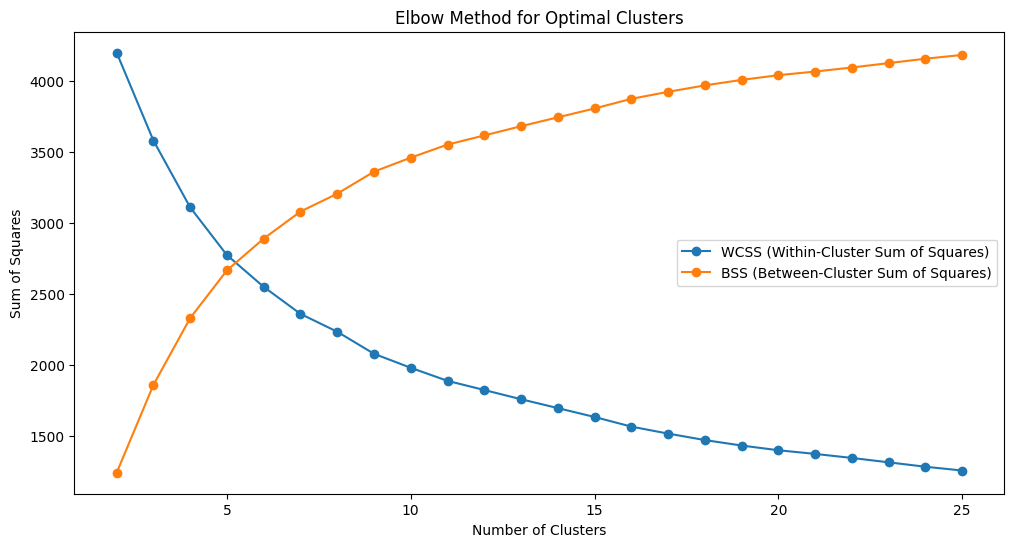

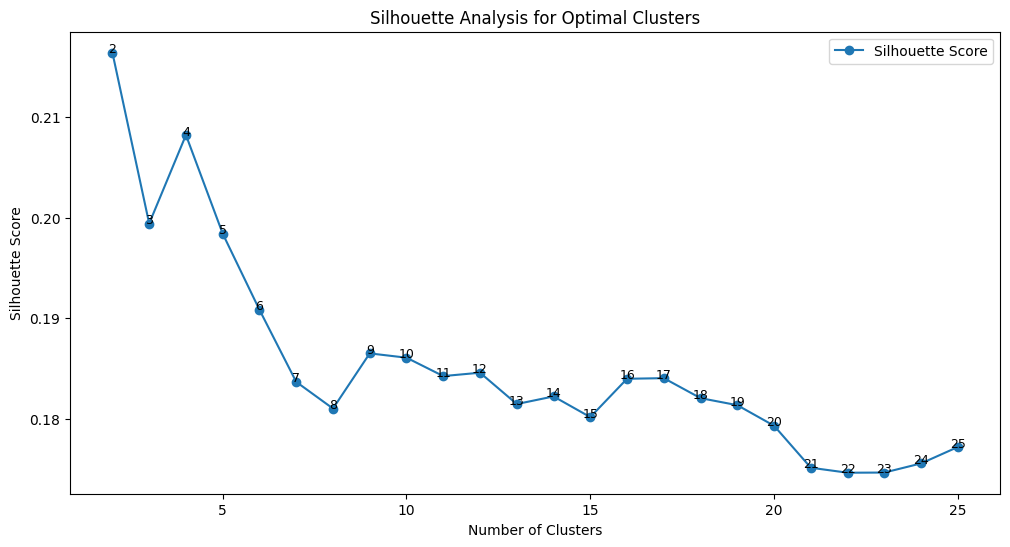

In [53]:
from sklearn.metrics import silhouette_score

# Function to find the optimal number of clusters using the Elbow Method and Silhouette Analysis
def find_optimal_clusters(embeddings, max_clusters=10):
    wcss = []  # Within-Cluster Sum of Squares
    bss = []  # Between-Cluster Sum of Squares
    silhouette_scores = []  # Silhouette Scores
    cluster_range = range(2, max_clusters + 1)

    # Calculate Total Sum of Squares (TSS)
    tss = np.sum((embeddings - np.mean(embeddings, axis=0))**2)

    for n_clusters in tqdm(cluster_range, desc="Finding optimal clusters"):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(embeddings)

        # Calculate WCSS
        wcss.append(kmeans.inertia_)

        # Calculate BSS
        bss.append(tss - kmeans.inertia_)

        # Calculate Silhouette Score
        silhouette_avg = silhouette_score(embeddings, kmeans.labels_)
        silhouette_scores.append(silhouette_avg)

    # Plot Elbow Method for WCSS and BSS
    plt.figure(figsize=(12, 6))
    plt.plot(cluster_range, wcss, marker='o', label='WCSS (Within-Cluster Sum of Squares)')
    plt.plot(cluster_range, bss, marker='o', label='BSS (Between-Cluster Sum of Squares)')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Sum of Squares')
    plt.title('Elbow Method for Optimal Clusters')
    plt.legend()
    plt.show()

    # Plot Silhouette Scores
    plt.figure(figsize=(12, 6))
    plt.plot(cluster_range, silhouette_scores, marker='o', label='Silhouette Score')
    # Plot the cluster number above each point
    for i, score in enumerate(silhouette_scores):
        plt.text(cluster_range[i], score, str(cluster_range[i]), fontsize=9, ha='center')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Analysis for Optimal Clusters')
    plt.legend()
    plt.show()

    return wcss, bss, silhouette_scores

# Find the optimal number of clusters
wcss, bss, silhouette_scores = find_optimal_clusters(question_embeddings, max_clusters=25)

<div class="alert alert-block alert-success">
After cluster analysis, we determined that the optimal number of clusters for this dataset is 4.
</div>

We used KMeans (a centroid-based clustering algorithm that partitions data into k=4 distinct clusters) and t-SNE (t-distributed Stochastic Neighbor Embedding, a dimensionality reduction technique for visualizing high-dimensional data) to visualize the clusters formed from the embeddings of the question feature.

/opt/homebrew/Caskroom/miniforge/base/envs/NLP/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


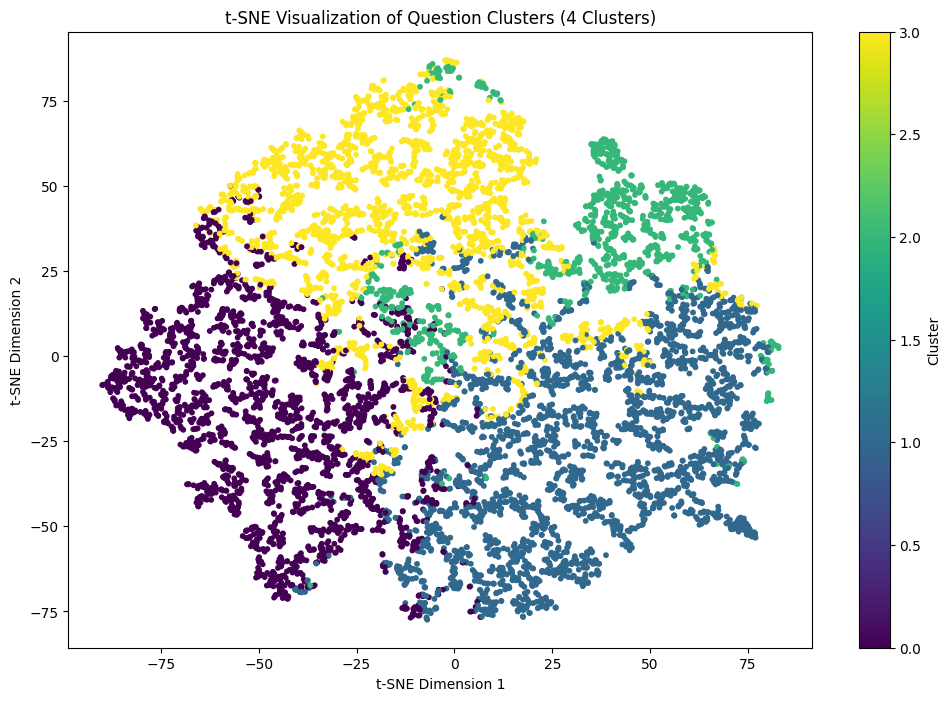

Cluster 0:
who (1263), what (1251), when (177), first (159), author (150), game (133), why (132), new (128), event (119), how (118)


Cluster 1:
what (3058), context (671), according (389), mentioned (329), author (279), main (266), when (152), how (144), used (135), benefit (131)


Cluster 2:
what (1050), service (201), feature (192), offered (114), offer (100), amenity (88), purpose (76), type (72), provided (70), available (69)


Cluster 3:
what (2131), according (269), who (263), purpose (222), how (141), new (134), main (125), role (99), program (87), context (85)




In [ ]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from collections import Counter

n_clusters = 4

# Perform K-Means clustering with n_clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
train_df['cluster'] = kmeans.fit_predict(question_embeddings)

# Reduce dimensions of question embeddings using t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
question_embeddings_2d = tsne.fit_transform(question_embeddings)

# Plot the t-SNE results
plt.figure(figsize=(12, 8))
plt.scatter(question_embeddings_2d[:, 0], question_embeddings_2d[:, 1], c=train_df['cluster'], cmap='viridis', s=10)
plt.colorbar(label='Cluster')
plt.title(f't-SNE Visualization of Question Clusters ({n_clusters} Clusters)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

# Function to extract topics for each cluster
def get_cluster_topics(df, cluster_col, text_col, top_n=10):
    cluster_topics = {}
    for cluster_id, group in df.groupby(cluster_col):
        # Tokenize all questions in the cluster
        all_words = [word for question in group[text_col] for word in word_tokenize(question.lower())]
        # Count word frequencies
        word_freq = Counter(all_words)
        # Get the top N most common words
        cluster_topics[cluster_id] = word_freq.most_common(top_n)
    return cluster_topics

# Get topics for each cluster
topics = get_cluster_topics(train_df, cluster_col='cluster', text_col='question', top_n=10)

# Display topics for each cluster
for cluster_id, words in topics.items():
    print(f"Cluster {cluster_id}:")
    print(", ".join([f"{word} ({count})" for word, count in words]))
    print("\n")

We used PCA (Principal Component Analysis, a technique that projects data onto principal components to reduce dimensionality) to visualize the clusters formed from the embeddings of the question feature.

In [55]:
import plotly.express as px
from sklearn.decomposition import PCA
# Reduce dimensions of question embeddings to 3D using PCA
pca = PCA(n_components=3)
question_embeddings_3d = pca.fit_transform(question_embeddings)


# Prepare a DataFrame for visualization
visualization_df = pd.DataFrame({
    'PCA Dimension 1': question_embeddings_3d[:, 0],
    'PCA Dimension 2': question_embeddings_3d[:, 1],
    'PCA Dimension 3': question_embeddings_3d[:, 2],
    'Cluster': train_df['cluster'],
    'Question': train_df['question']
})
# Create an interactive 3D scatter plot with a larger figure size
fig = px.scatter_3d(
    visualization_df,
    x='PCA Dimension 1',
    y='PCA Dimension 2',
    z='PCA Dimension 3',
    color='Cluster',
    hover_data=['Question'],  # Show the question on hover
    title='Interactive 3D Visualization of Question Clusters',
    width=1200,  # Set the width of the plot
    height=1000   # Set the height of the plot
)

# Show the plot
fig.show()

<div class="alert alert-block alert-success">
Both PCA and t-SNE visualizations demonstrate a clear separation between clusters, indicating that the chosen number of clusters and the application of KMeans clustering are appropriate and well-justified for this dataset.
</div>

# 🔠 TF-IDF analysis

In this section we performed TF-IDF analysis to extract the most important words from documents in our dataset. TF-IDF (Term Frequency-Inverse Document Frequency) is a statistical measure that evaluates how relevant a word is to a document in a collection of documents.

The TF-IDF score is calculated using the formula:

$$\text{TF-IDF}(t, d, D) = \text{TF}(t, d) \times \text{IDF}(t, D)$$

Where:
- $\text{TF}(t, d)$ is the term frequency of term $t$ in document $d$ (how many times the term appears in the document)
- $\text{IDF}(t, D)$ is the inverse document frequency of term $t$ in document collection $D$, calculated as $\log\frac{N}{df_t}$ where $N$ is the total number of documents and $df_t$ is the number of documents containing term $t$

We applied TF-IDF analysis in three different ways:
1. Context-only analysis: Applied TF-IDF on just the context fields
2. Question-only analysis: Applied TF-IDF on just the question fields
3. Combined analysis: Applied TF-IDF on the combined context and question fields

For each document, we extracted the top 5 words with the highest TF-IDF scores, indicating the most distinctive terms for that specific document. These terms represent the key concepts that distinguish each document from others in the corpus.

We also visualized the results using color-coded highlighting, where each top TF-IDF word in a document was highlighted with a unique color and accompanied by a bar chart showing the relative importance of each term. This allowed us to quickly identify the most informative words in each document and observe patterns across the dataset.

In [56]:
# Convert the list of tokenized dictionaries into a DataFrame
train_df_tokenized = pd.DataFrame(train_df_tokenized, columns=['context', 'question', 'answer'])

train_df_tokenized.head(1)

,context,question,answer
0,"[caption, tasmanian, berry, grower, nic, hansen, showing, macau, chef, antimo, merone, around, property, part, export, engagement, activities, rise, rise, australian, strawberry, raspberry, blackberry, industries, seen, sectors, redouble, international, trade, focus, release, dedicated, export, plan, grow, global, presence, next, 10, years, driven, significant, grower, input, berry, export, summary, 2028, maps, sectors, current, position, want, markets, next, steps, hort, innovation, trade, manager, jenny, van, de, meeberg, said, value, volume, raspberry, blackberry, exports, rose, 100, per, cent, 2016, said, australian, strawberry, industry, experienced, similar, success, almost, 30, per, cent, rise, export, volume, 26, per, cent, rise, value, period, australian, berry, sectors, firm, position, ...]","[berry, export, summary, 2028, purpose]","[berry, export, summary, 2028, dedicated, export, plan, australian, strawberry, raspberry, blackberry, industries, maps, sectors, current, position, want, markets, next, steps, purpose, plan, grow, global, presence, next, 10, years]"


In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert tokenized lists back into strings for TF-IDF processing because TfidfVectorizer expects text input as strings
train_df_tokenized['context_str'] = train_df_tokenized['context'].apply(lambda tokens: ' '.join(tokens))
train_df_tokenized['question_str'] = train_df_tokenized['question'].apply(lambda tokens: ' '.join(tokens))

# Option 1: Apply TF-IDF on the 'context' field to compute the term frequency-inverse document frequency for words in the 'context' field
vectorizer_context = TfidfVectorizer()
tfidf_context = vectorizer_context.fit_transform(train_df_tokenized['context_str'])

# Option 2: Apply TF-IDF on the 'question' field to compute the term frequency-inverse document frequency for words in the 'question' field
vectorizer_question = TfidfVectorizer()
tfidf_question = vectorizer_question.fit_transform(train_df_tokenized['question_str'])

# Option 3: Apply TF-IDF on the combined 'context' and 'question' fields
train_df_tokenized['combined'] = train_df_tokenized['context_str'] + ' ' + train_df_tokenized['question_str']

# This vectorizer will compute the term frequency-inverse document frequency for words in the combined field
vectorizer_combined = TfidfVectorizer()
tfidf_combined = vectorizer_combined.fit_transform(train_df_tokenized['combined'])

In [58]:
# Convert the sparse matrix of TF-IDF values for 'context' into a pandas DataFrame

tfidf_context_df = pd.DataFrame(tfidf_context.toarray(), columns=vectorizer_context.get_feature_names_out())
tfidf_question_df = pd.DataFrame(tfidf_question.toarray(), columns=vectorizer_question.get_feature_names_out())
tfidf_combined_df = pd.DataFrame(tfidf_combined.toarray(), columns=vectorizer_combined.get_feature_names_out())

print("Shape of TF-IDF Context DataFrame:", tfidf_context_df.shape)
print("Shape of TF-IDF Question DataFrame:", tfidf_question_df.shape)
print("Shape of TF-IDF Combined DataFrame:", tfidf_combined_df.shape)

Shape of TF-IDF Context DataFrame: (9598, 128209)
Shape of TF-IDF Question DataFrame: (9598, 16571)
Shape of TF-IDF Combined DataFrame: (9598, 128231)


In [ ]:
word_scores = tfidf_context_df.sum(axis=0).sort_values(ascending=False)

# Plot top 20 words by TF-IDF score
top_n = 20
top_words = word_scores.head(top_n)

plt.figure(figsize=(10, 6))
colors = plt.cm.tab20.colors  # Use a colormap for different colors
top_words.plot(kind='bar', color=[colors[i % len(colors)] for i in range(len(top_words))])
plt.title(f"Top {top_n} Words by TF-IDF Score")
plt.xlabel("Words")
plt.ylabel("Total TF-IDF Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-success">
This TF-IDF analysis identifies the top 20 words that are most characteristic of the context data, with "one", "said", and "like" ranking highest. The predominance of general, content-rich words rather than typical stop words suggests effective preprocessing and highlights key themes or topics present in the dataset. These results provide insight into the most informative terms.
</div>

In [ ]:
#Add a column to the DataFrame with the top N words for each document
feature_names = vectorizer_context.get_feature_names_out()

# Function to get top N words for a single document
def get_top_n_words(row, n):
    row_data = row.toarray().flatten()
    top_indices = row_data.argsort()[::-1][:n]

    return [(feature_names[i], row_data[i]) for i in top_indices if row_data[i] > 0]


# Apply the function to each row of the TF-IDF DataFrame
N = 5 # Number of top words to extract
#Next to the word there is also the tfidf score
train_df_tokenized[f'top_{N}_tfidf_words_context'] = [
    get_top_n_words(tfidf_context[i], N) for i in range(tfidf_context.shape[0])
]

In [ ]:
train_df_tokenized.tail(1)

In [ ]:
from matplotlib.colors import to_hex
import random
import re
from IPython.display import display, HTML

def highlight_words_in_text_colored(text, words_to_highlight, colors):
    """
    Highlight specific words in a given text with corresponding colors.
    """
    for (word, _), color in zip(words_to_highlight, colors):
        # Use regex to match whole words only
        text = re.sub(rf'\b{re.escape(word)}\b', f"<mark style='background-color:{color};'>{word}</mark>", text)
    return text

def plot_and_highlight_document_colored(doc_index, title='Top TF-IDF Words'):
    """
    Plot top TF-IDF words with different colors and highlight them in the document with the same colors.
    """
    word_score_pairs = train_df_tokenized.loc[doc_index, f'top_{N}_tfidf_words_context']
    words, scores = zip(*word_score_pairs)

    # Generate unique colors for each word
    colors = [to_hex(plt.cm.tab10(i % 10)) for i in range(len(words))]

    # Plot top TF-IDF words with different colors
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.barh(words[::-1], scores[::-1], color=colors[::-1])  # reverse for descending order
    plt.xlabel('TF-IDF Score')
    plt.title(title)
    plt.tight_layout()

    # Highlight words in the document with the same colors
    highlighted_text = highlight_words_in_text_colored(train_df_tokenized.loc[doc_index, 'context_str'], word_score_pairs, colors)
    plt.subplot(1, 2, 2)
    plt.axis('off')
    display(HTML(f"<div style='font-size:14px; line-height:1.6;'>{highlighted_text}</div>"))
    plt.show()

# Example: visualize the first 5 documents

documents_to_show = 3
for i in range(3):
    plot_and_highlight_document_colored(i, title=f'Document {i+1} - Top TF-IDF Words')

# 🗂️ Dataset indexing & searching

This section implements an efficient document retrieval system using TF-IDF (Term Frequency-Inverse Document Frequency) vectorization and cosine similarity. Here's what's happening:

1. **Indexing**: We create a search index from our dataset's context fields by:
   - Tokenizing each document into individual words
   - Building a Gensim Dictionary that maps words to unique IDs
   - Converting documents to bag-of-words representation
   - Applying TF-IDF transformation to emphasize important terms
   - Creating a similarity matrix for efficient retrieval

2. **Search functionality**: We implement a search function that:
   - Takes a user query and preprocesses it (tokenization, stopword removal)
   - Converts the query to the same TF-IDF space as our corpus
   - Calculates cosine similarity between the query and all documents
   - Returns the top 3 most relevant documents with their similarity scores

3. **Interactive interface**: We provide an interactive search widget where you can type any query in the search bar and see real-time results showing matching contexts, questions, answers, and relevance scores


In [ ]:
from gensim import corpora, models, similarities

# Create the dictionary and corpus for the TF-IDF model
texts = train_df['context']
texts = [word_tokenize(text.lower()) for text in texts]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Build the TF-IDF vectorizer
tfidf_model = models.TfidfModel(corpus)
corpus_tfidf = tfidf_model[corpus]

# Create the similarity index
index = similarities.MatrixSimilarity(corpus_tfidf)

In [ ]:
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output

# Function to get the most similar documents
def search(query_tokens, top_k=3):
    query_bow = dictionary.doc2bow(query_tokens)
    query_tfidf = tfidf_model[query_bow]
    sims = index[query_tfidf]  # cosine similarities
    top_indices = sorted(enumerate(sims), key=lambda x: -x[1])[:top_k]
    results = train_df.iloc[[i for i, _ in top_indices]].copy()
    results['similarity'] = [score for _, score in top_indices]
    return results[['context', 'question', 'answer', 'similarity']]

# Create an output widget for displaying the results
output_area = widgets.Output()

# Function to handle search queries
def interactive_search(change):
    query = change['new']
    query_tokens = preprocess(query)  # Tokenize and preprocess the query
    result_df = search(query_tokens)
    with output_area:
        clear_output(wait=True)  # Clear only the output area
        output_area.append_display_data(result_df)  # Append the resulting dataframe to the output area

# Create a text input widget
search_bar = widgets.Text(
    value='',
    placeholder='Enter your search query',
    description='Search:',
    layout=widgets.Layout(width='50%')
)

# Add an observer to the search bar
search_bar.observe(interactive_search, names='value')

# Display the search bar and output area
display(search_bar, output_area)

# 📝 Sentence embedding (all-MiniLM-L6-v2 on context)

This section converts text contexts into dense vector representations using the `all-MiniLM-L6-v2` model from SentenceTransformer. Unlike word-level embeddings, sentence embeddings capture semantic meaning for entire text passages in a fixed-size vector. The model used maps sentences & paragraphs to a 384-dimensional dense vector space and can be used for tasks like clustering or semantic search.

The embedding is performed on the context feature of the dataset, and we then use the function `community_detection` to find, in the embeddings, all communities (i.e., embeddings that are close—closer than a specified threshold). This is used for clustering. We then plot the distribution of the clusters and decide to use BERTopic to effectively cluster the context feature.

In [ ]:
from sentence_transformers import SentenceTransformer, util

# Model for computing sentence embeddings.
model = SentenceTransformer('all-MiniLM-L6-v2')

sentence_embeddings = model.encode(train_df['context'].tolist(), convert_to_tensor=True, show_progress_bar=True)

In [ ]:
# Perform community detection on the sentence embeddings
clusters = util.community_detection(sentence_embeddings, min_community_size=10, threshold=0.6, show_progress_bar=True)

print("Number of clusters found:", len(clusters))
cluster_sizes = [len(cluster) for cluster in clusters]
print("Cluster coverage:", sum(cluster_sizes) / len(train_df))

# Plot the distribution of cluster sizes
plt.figure(figsize=(12, 6))
sns.histplot(cluster_sizes, kde=True)
plt.title('Distribution of Cluster Sizes')
plt.xlabel('Cluster Size')
plt.ylabel('Frequency')
plt.show()

<div class="alert alert-block alert-warning">
Using standard sentence embeddings combined with the "find communities" function results in a large number of small clusters, as shown in the distribution above. This fragmentation indicates that the approach is not well-suited for topic modeling analysis, since meaningful topics typically require larger, more coherent groups of records.
</div>

# 🎩 Topic Modelling (BERTopic)

BERTopic is an advanced topic modeling library that leverages transformer embeddings to discover topics within large text collections. Here's how it works:

**Core process:**
- Uses SentenceTransformer embeddings as semantic document representations
- Applies HDBSCAN clustering to group similar documents
- Creates topic representations by extracting distinctive keywords using c-TF-IDF
- Generates hierarchical topic structures and visualizations

Furthermore, BERTopic provides a set of built-in visualization methods to explore the topics generated.

**Why use BERTopic instead of SentenceTransformer alone?**

While SentenceTransformer (e.g., all-MiniLM-L6-v2) provides powerful sentence embeddings for converting text into dense vectors, it does not offer an end-to-end topic modeling pipeline. BERTopic builds on top of these embeddings and adds robust clustering (using HDBSCAN), topic representation, and visualization capabilities. This makes BERTopic especially effective for discovering interpretable topics in large text datasets, whereas SentenceTransformer alone only provides representations without direct topic extraction.

In [ ]:
# Install bertopic if not already installed

if IN_KAGGLE or IN_COLAB:
  ! pip install -q bertopic

In [ ]:
from bertopic import BERTopic

# Create a BERTopic model
topic_model = BERTopic(verbose=True)
topics, probs = topic_model.fit_transform(train_df['context'])


In [ ]:
len(topics)

In [ ]:
# add the topics for each document to the DataFrame
train_df['topic'] = topics

In [ ]:
total_records = len(train_df)
records_with_topic = len(train_df[train_df['topic'] != -1])
percentage_with_topic = (records_with_topic / total_records) * 100

print(f"Number of records with any topic assigned: {records_with_topic} ({percentage_with_topic:.2f}%)")

In [ ]:
topic_relevant_words = {}
for topic in set(topics):
    topic_relevant_words[topic] = [word for word, _ in topic_model.get_topic(topic)]

In [ ]:
print("Number of unique topics:", len(topic_relevant_words))
topic_relevant_words

In [ ]:
# Visualize the topics
topic_model.visualize_topics()

<div class="alert alert-block alert-info">
The Intertopic Distance Map shows that several topics are positioned close to each other, suggesting that they can be grouped into broader thematic clusters. This indicates the presence of related or overlapping content among the topics.
</div>

In [ ]:
# visualize the document representation
topic_model.visualize_documents(train_df['context'].tolist(), topics = list(range(20)), hide_document_hover=True)

In [ ]:
topic_model.visualize_document_datamap(train_df['context'].tolist(), enable_search=True, interactive=True)

<div class="alert alert-block alert-info">
We also introduced additional interactive plots to better understand how topics are assigned within the context feature.
</div>

In [ ]:
# visualize the topic representation
topic_model.visualize_barchart(top_n_topics=40)

<div class="alert alert-block alert-info">
The bar chart generated displays the top 5 most relevant words for each of the first 40 topics. This visualization provides an intuitive overview of the key terms characterizing each topic, making it easier to interpret and compare the main themes present in the dataset.
</div>

In [ ]:
topic_no = 27

print(f"Topic {topic_no}:")
# get the topic representation
for topic, prob in topic_model.get_topic(topic_no):
    print(f"{topic}: {prob:.2f}")
# find all the documents in a topic and relative topics in a pretty format
for i in topic_model.get_representative_docs(topic_no):

    index = train_df[train_df['context'].str.contains(i)].index[0]
    print(f'Document {index}\nContext: {i}')
    # find the record in the original dataset by a serach on the context and print question and answer
    print("Question:", train_df[train_df['context'].str.contains(i)]['question'].values[0])
    print("Answer:", train_df[train_df['context'].str.contains(i)]['answer'].values[0])

In [ ]:
# sviualize the word topics without the document representation
topic_model.visualize_heatmap(top_n_topics=50)

<div class="alert alert-block alert-success">
The similarity matrix visualizes the pairwise similarity scores between topics, with darker shades indicating higher similarity. For example, topics <b>recipe_cup_cheese</b> and <b>restaurant_dish_food</b> exhibit a relatively high similarity score. This is expected, as both topics are related to food and culinary themes. Such insights help to identify groups of related topics and provide a deeper understanding of the overall thematic organization within the dataset.
</div>

## Hierarchical clustering on topics

BERTopic enables hierarchical organization of topics using agglomerative clustering, which progressively merges similar topics into larger clusters. This creates a tree-like structure showing topic relationships at different granularity levels.

However, as clusters grow larger in the hierarchy, clustering quality tends to deteriorate significantly. This is because semantic coherence decreases when diverse topics are merged, leading to a loss of topic specificity and interpretability.

In [ ]:
hierarchical_topics = topic_model.hierarchical_topics(train_df['context'].tolist())

In [ ]:
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [ ]:
itables.show(hierarchical_topics.sort_values(by='Distance', ascending=False), max_rows=1000)

# 💊 Discover Context Containing Toxic Content

This section identifies and labels toxic content using a weakly supervised approach:

1. **Topic Extraction**: Topics and keywords are extracted using BERTopic.
2. **Toxic Keyword Detection**: Profanity words are downloaded and matched against topic keywords to identify toxic topics.
3. **Filtering**: Non-toxic false positives (e.g., "wang", "sexy") are removed, and topics containing fewer than 4 toxic-relevant words are excluded to reduce noise.
4. **Labeling**: Documents linked to toxic topics are labeled as toxic (`1`).

This method efficiently labels toxic content without manual annotation.

In [ ]:
# convert to list
topics_list = []
for topic, words in topic_model.get_topics().items():
    for word in words:
        topics_list.append(word[0])

# count the frequency of the relevant words
topic_word_counts = Counter(topics_list)

# remove duplicates
topics_list = list(set(topics_list))
len(topics_list)

In [ ]:
wordcloud = WordCloud(width=800, height=500).generate_from_frequencies(topic_word_counts)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Topics")
plt.show()


In [ ]:
# Get the top 20 most frequent words
n = 30
top_n_words = dict(sorted(topic_word_counts.items(), key=lambda item: item[1], reverse=True)[:n])

# Plot the frequency of the top 20 relevant words as a horizontal bar chart
plt.figure(figsize=(12, 10))
plt.barh(list(top_n_words.keys()), list(top_n_words.values()), color='skyblue')
plt.title(f'Frequency of Top {n} Relevant Words in Topics')
plt.xlabel('Frequency')
plt.ylabel('Relevant Words')
plt.gca().invert_yaxis()  # To display the most frequent word at the top
plt.show()

In [ ]:
# download profanity words
!wget https://raw.githubusercontent.com/coffee-and-fun/google-profanity-words/refs/heads/main/data/en.txt -O profanity_words.txt

# Read the profanity words into a set
with open('profanity_words.txt', 'r') as f:
    profanity_words = set(f.read().splitlines())

toxic_topics = []

for topic in topics_list:
    if topic in profanity_words:
        toxic_topics.append(topic)

print("Toxic topics:", toxic_topics)

In [ ]:
# Manually remove some words from the toxic topics list that can be considered as non-toxic
if "wang" in toxic_topics:
    toxic_topics.remove("wang")
if "sexy" in toxic_topics:
    toxic_topics.remove("sexy")

toxic_topics

In [ ]:
toxic_topic_ids = []

# Check if the words in the topics are in the toxic topics list and get the topic ids
for id, words in topic_relevant_words.items():
    for word in words:
        if word in toxic_topics:
            toxic_topic_ids.append(id)
            break

# Remove duplicates
toxic_topic_ids = list(set(toxic_topic_ids))
toxic_topic_ids

# Print the toxic topics
for id in toxic_topic_ids:
    print(f"Topic {id}: {topic_relevant_words[id]}")

In [ ]:
# count the number of relevant words that are toxic for each topic using the profanity_words
toxic_word_counts = {}
for topic, words in topic_relevant_words.items():
    toxic_word_counts[topic] = len([word for word in words if word in toxic_topics])

# remove topics with less than 5 toxic words
for id in toxic_topic_ids:
    if toxic_word_counts[id] < 4:
        toxic_topic_ids.remove(id)

In [ ]:
# Print the toxic topics after filtering
print("Filtered Toxic Topics:")
for id in toxic_topic_ids:
    print(f"Topic {id}: {topic_relevant_words[id]}")

In [ ]:
# Function to label toxic topics
def label_toxic_topics(row):
    if row['topic'] in toxic_topic_ids:
        return int(1)
    else:
        return int(0)
    
# # Apply the function to the DataFrame
tqdm.pandas(desc="Labeling toxic topics")
train_df['toxic'] = train_df.progress_apply(label_toxic_topics, axis=1)

# Count the number of toxic topics
toxic_count = train_df['toxic'].sum()
print(f"Number of toxic topics: {int(toxic_count)}")
print(f"Percentage of toxic topics: {toxic_count / len(train_df) * 100:.2f}%")

In [ ]:
train_df[train_df['toxic'] == 1].head(1)

## Train binary classifier

# 💊 Train Binary Classifier

After identifying toxic records, this section implements a BERT-based binary classifier to automatically detect toxic content in new texts:

**Data preparation:**
- Created a balanced dataset by undersampling non-toxic examples (3:1 ratio)
- Removed records lacking topic assignments
- Split data into train (80%), validation (8%) and test (12%) sets with stratification

The model uses the `bert-base-multilingual-uncased` architecture, fine-tuned for sequence classification tasks. Its performance was evaluated using a confusion matrix alongside standard classification metrics.

The classifier can determine if new text contains toxic content with a simple function call, complementing the topic-based detection approach with direct predictive capability.

In [ ]:
train_df_binary = train_df[['context', 'question', 'answer', 'toxic', 'topic']].copy()
# remove records with cluster -1
train_df_binary = train_df_binary[train_df_binary['topic'] != -1]
print("Number of records with cluster -1:", len(train_df) - len(train_df_binary))
train_df_binary = train_df_binary.reset_index(drop=True)
train_df_binary.drop(columns=['topic'], inplace=True)
train_df_binary.head(10)

<div class="alert alert-block alert-warning">
<b>Note:</b> BERTopic clustered approximately 50% of the records. The remaining records were not assigned to any topic, likely due to insufficient semantic similarity to form coherent clusters.
</div>


In [ ]:
# plot distribution of toxic and non-toxic records
plt.figure(figsize=(8, 6))
sns.countplot(x='toxic', data=train_df_binary)
plt.title('Distribution of Toxic and Non-Toxic Records')
plt.xlabel('Toxicity')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Toxic', 'Toxic'])
plt.show()

print("Number of toxic records:", len(train_df_binary[train_df_binary['toxic'] == 1]))
print("Number of non-toxic records:", len(train_df_binary[train_df_binary['toxic'] == 0]))


<div class="alert alert-block alert-warning">
<b>Note:</b> The dataset is highly skewed, with the majority of records labeled as non-toxic. To address this class imbalance, we applied undersampling to the non-toxic class using a 3:1 ratio, ensuring a more balanced distribution for subsequent analysis and modeling.
</div>

In [ ]:
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

# Separate majority and minority classes
majority_class = train_df_binary[train_df_binary['toxic'] == 0]
minority_class = train_df_binary[train_df_binary['toxic'] == 1]

# Perform undersampling on the majority class to match the size of the minority class
majority_class_undersampled = resample(
    majority_class,
    replace=False,  # Sample without replacement
    n_samples=len(minority_class)*3,  # Select a number of samples to match the minority class
    random_state=42
)

# Combine the undersampled majority class with the minority class
balanced_df = pd.concat([majority_class_undersampled, minority_class])

# Split the balanced dataset into training and testing sets
X_train, X_val_test, y_train, y_val_test = train_test_split(
    balanced_df['context'],
    balanced_df['toxic'],
    test_size=0.2,
    random_state=42,
    stratify=balanced_df['toxic']
)

X_val, X_test, y_val, y_test = train_test_split(
    X_val_test,
    y_val_test,
    test_size=0.4,
    random_state=42,
    stratify=y_val_test
)

print("Train set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))
print("Class distribution in train set:\n", y_train.value_counts())
print("Class distribution in test set:\n", y_test.value_counts())

In [ ]:
# plot distribution of toxic and non-toxic records
plt.figure(figsize=(8, 6))
sns.countplot(x='toxic', data=balanced_df)
plt.title('Distribution of Toxic and Non-Toxic Records')
plt.xlabel('Toxicity')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Toxic', 'Toxic'])
plt.show()

print("Number of toxic records:", len(balanced_df[balanced_df['toxic'] == 1]))
print("Number of non-toxic records:", len(balanced_df[balanced_df['toxic'] == 0]))


In [ ]:
model_name = 'bert-base-multilingual-uncased'

In [ ]:
bert = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(y_train.value_counts()))

In [ ]:
import torch

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
    print("Using GPU")
elif torch.backends.mps.is_available():
    device = "mps"
    print("Using Apple Silicon GPU")
else:
    print("Using CPU")
print(device)

In [ ]:
bert = bert.to(device)

In [ ]:
print(bert)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
train_data = [{'text': txt, 'label': lbl} for txt, lbl in zip(X_train, y_train)]
val_data = [{'text': txt, 'label': lbl} for txt, lbl in zip(X_val, y_val)]
test_data = [{'text': txt, 'label': lbl} for txt, lbl in zip(X_test, y_test)]

train_data = Dataset.from_list(train_data)
test_data = Dataset.from_list(test_data)

In [ ]:
data = DatasetDict()
data['train'] = train_data
data['validation'] = test_data
data['test'] = test_data

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding=True, truncation=True)

tokenized_data = data.map(tokenize_function, batched=True, desc="Tokenizing data")

In [ ]:
# To avoid the train on local machine
if IN_COLAB or IN_KAGGLE:
    BINARY_CLASSIFIER_TRAINING = True
else:
    BINARY_CLASSIFIER_TRAINING = False

In [ ]:
if BINARY_CLASSIFIER_TRAINING:
    ! pip install 'accelerate>=0.26.0'

In [ ]:
if BINARY_CLASSIFIER_TRAINING:
    os.environ["WANDB_DISABLED"] = "true"

    training_args = TrainingArguments(
        "toxic-bert",
        per_device_train_batch_size=16,
        report_to=None,  # Disabling wandb callbacks
    )

In [ ]:
if BINARY_CLASSIFIER_TRAINING:
    trainer = Trainer(
        model=bert,
        args=training_args,
        train_dataset=tokenized_data['train'],
        eval_dataset=tokenized_data['validation']
    )

In [ ]:
if BINARY_CLASSIFIER_TRAINING:
    # Train the model
    trainer.train() 

    # Save the model
    trainer.save_model("toxic-bert")
    tokenizer.save_pretrained("toxic-bert")
    print("Model saved to toxic-bert directory")

In [ ]:
if BINARY_CLASSIFIER_TRAINING:
    # Train the model
    trainer.evaluate()

In [ ]:
! pip install -q kagglehub

In [ ]:
DOWLOAD_MODEL_KAGGLE = False

if DOWLOAD_MODEL_KAGGLE:
    
    import kagglehub
    kagglehub.model_download('martinimarcello00/bert/pytorch/bert-toxic-classifier')


In [ ]:
# Load model and tokenizer
model_path = "./toxic-bert"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Move to appropriate device
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
model = model.to(device)

print(model)

In [ ]:
if BINARY_CLASSIFIER_TRAINING:
    preds = trainer.predict(tokenized_data['test'])
    y_pred = torch.argmax(torch.tensor(preds.predictions), dim=1).numpy()
else:
        # Get the test data
    test_texts = X_test.tolist()
    test_encodings = tokenizer(test_texts, padding=True, truncation=True, return_tensors="pt")

    # Move tensors to the appropriate device
    device = model.device
    input_ids = test_encodings['input_ids'].to(device)
    attention_mask = test_encodings['attention_mask'].to(device)

    # Get predictions from the model
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = outputs.logits

    # Convert to numpy array
    preds = predictions.cpu().numpy()

    # Get predicted class (0 or 1)
    y_pred = np.argmax(preds, axis=1)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=['Non-Toxic', 'Toxic']))


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Toxic', 'Toxic'], yticklabels=['Non-Toxic', 'Toxic'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

<div class="alert alert-block alert-danger">
<b>Note:</b> The model is likely overfitting, as we performed undersampling on the toxic class, which represented less than 1% of the dataset.
We chose to proceed since the pipeline functions correctly, but additional data are needed to effectively fine-tune BERT for binary toxic classification.
</div>

In [ ]:
def predict_toxicity(text):
    # Prepare text for model
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Get prediction
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        prediction = torch.argmax(outputs.logits, dim=1).item()
        
    return "Toxic" if prediction == 1 else "Non-Toxic"

In [ ]:
result = predict_toxicity("Hello we are studyng NLP together")
print(result)

In [ ]:

result = predict_toxicity("Fuck you dumb asshole")
print(result)

# 🔮 Google Gemma 2b & Google T5 LLM model QA ability testing

In this section, we evaluated the question-answering capabilities of two language models:

- Models Used: Google's **gemma-2b-it** and Google's **flan-t5-base**.
- Testing Approach: We tested both models in two scenarios:
    - Zero-shot: Models were given only the question with no additional context.
    - Context-enhanced: Models were provided with relevant context alongside the question.

## Zero-Shot vs. Context-Enhanced Testing

**Zero-shot** testing evaluates a model's ability to answer questions using only its pre-trained knowledge. This approach tests what the model "knows" implicitly from its training data, without any additional information. We use zero-shot testing to assess the model's baseline capabilities and inherent knowledge limitations.

**Context-enhanced** testing provides the model with relevant information alongside the question. This simulates real-world retrieval-augmented generation (RAG) systems, where models can access external knowledge sources to improve their answers. By providing context, we test the model's ability to extract and synthesize information from provided text rather than relying solely on its parametric knowledge.

As expected, both models showed significantly improved performance when provided with relevant context. This confirms that while these language models contain impressive amounts of knowledge, they still benefit substantially from access to specific information relevant to the question at hand. The context-enhanced approach helps overcome limitations in the models' internal knowledge and reduces hallucinations by grounding responses in factual information.

In [ ]:
# Required for T5 model
! pip install -q sentencepiece

In [ ]:
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer
print(f"Transformers version: {transformers.__version__}")

In [ ]:
if IN_KAGGLE or IN_COLAB:
    torch.set_default_device("cuda")

# Load the model and tokenizer
gemma_model = AutoModelForCausalLM.from_pretrained(
    "google/gemma-2b-it",
    torch_dtype=torch.float16,
    trust_remote_code=True,
)
gemma_tokenizer = AutoTokenizer.from_pretrained("google/gemma-2b-it", trust_remote_code=True)

gemma_tokenizer.pad_token = gemma_tokenizer.eos_token

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

t5_model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base")
t5_tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")

print(t5_model.device)

In [ ]:
if not IN_KAGGLE and not IN_COLAB:
    # Move the model to GPU if available
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    gemma_model.to(device)
    t5_model.to(device)
else:
    gemma_model.to("cuda")
    t5_model.to("cuda")


print("Gemma model loaded successfully.")
print("T5 model loaded successfully.")
print("Gemma model device:", gemma_model.device)
print("T5 model device:", t5_model.device)

In [ ]:
n_test = 50

train_df = dataset['train'].to_pandas()
train_df = train_df.dropna()
train_df = train_df.reset_index(drop=True)


subset = train_df.sample(n_test, random_state=42)

In [ ]:
def store_answer(entry, generation_function, context=False):
    question = entry['question']
    context = entry['context']
    if context:
        answer = generation_function(question, context)
    else:
        answer = generation_function(question)
    return answer

## Zero shot

<div class="alert alert-block alert-warning">
<b>Note:</b> We chose to perform only zero-shot inference with T5 and Gemma2, as these models are pretrained for QA tasks and do not require additional examples to generate answers. Providing extra examples (few shots learning) would unnecessarily increase the input size without improving performance, especially since the questions are highly diverse.
</div>

In [ ]:
import os

# Initialize variables
gemma_df = pd.DataFrame()
t5_df = pd.DataFrame()

# Initialize booleans to track file existence
gemma_exists = False
t5_exists = False

try:
    # Check and load subset_with_generated_answers_with_context_gemma.csv
    if os.path.exists('subset_with_generated_answers_with_context_gemma.csv'):
        gemma_df = pd.read_csv('subset_with_generated_answers_with_context_gemma.csv')
        gemma_exists = True
    else:
        gemma_df['question'] = subset['question']
        gemma_df['context'] = subset['context']
        gemma_df['answer'] = subset['answer']

    # Check and load subset_with_generated_answers_with_context_t5.csv
    if os.path.exists('subset_with_generated_answers_with_context_t5.csv'):
        t5_df = pd.read_csv('subset_with_generated_answers_with_context_t5.csv')
        t5_exists = True
    else:
        t5_df['question'] = subset['question']
        t5_df['context'] = subset['context']
        t5_df['answer'] = subset['answer']

except Exception as e:
    print(f"An error occurred: {e}")

# Print the status of file loading
print(f"subset_with_generated_answers_with_context_gemma.csv loaded: {gemma_exists}")
print(f"subset_with_generated_answers_with_context_t5.csv loaded: {t5_exists}")

In [ ]:
def generate_answer_zeroshot(entry,model,tokenizer):
    question = entry['question']
    if model == gemma_model:

        prompt = f"""You are a precise and concise assistant.
    Answer the question briefly and do not add anything else—no explanations, comments, or formatting.

    Question: {question}
    Answer:"""
        
    else:
      prompt = f"Answer the following question: {question}"
    
    if not IN_KAGGLE and not IN_COLAB:
        inputs = tokenizer(prompt, return_tensors="pt").to('mps')  # Use "cuda" or correct device
    else:
        inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

    if model == gemma_model:
        outputs = model.generate(
            **inputs,
            max_new_tokens=100,
            pad_token_id=tokenizer.eos_token_id
        )
    else:  
        outputs = model.generate(
            **inputs,
            max_new_tokens=100
        )

    text = tokenizer.decode(outputs[0], skip_special_tokens=True)


    if(model == gemma_model):
            # Remove everything before the first occurrence of "Answer:" (if needed)
        match = re.search(r'Answer:\s*(.*)', text, re.DOTALL)
        if match:
            return match.group(1).strip()
        else:
            return text.strip()
    else:
        # Clean the T5 output
        return text.strip()


In [ ]:
if not gemma_exists:
    tqdm.pandas(desc="Generating answers using zero-shot gemma-2b-it")
    gemma_df['zeroShot_answer'] = subset.progress_apply(lambda row: generate_answer_zeroshot(row, gemma_model, gemma_tokenizer), axis=1)

In [ ]:
if not t5_exists:
    tqdm.pandas(desc="Generating answers using zero-shot phi-2")
    t5_df['zeroShot_answer'] = subset.progress_apply(lambda row: generate_answer_zeroshot(row, t5_model, t5_tokenizer), axis=1)

In [ ]:
gemma_df[['question', 'answer', 'zeroShot_answer']].head(5)

In [ ]:
t5_df[['question', 'answer', 'zeroShot_answer']].head(5)

In [ ]:
def generate_answer_zeroshot_context(entry, model, tokenizer):
    question = entry['question']
    context = entry.get('context', '')  # safely get context if exists

    if model == gemma_model:
        prompt = f"""You are a precise and concise assistant.
Answer the question briefly and do not add anything else—no explanations, comments, or formatting.

Context: {context}
Question: {question}
Answer:"""
    else:
        prompt = f"""You are a precise and concise assistant.
        Use the context below to answer the question accurately.
        Provide only the answer; do not repeat the question or the context.

        Context:
        {context}

        Question: {question}
        Answer:"""
    # Set device
    device = "cuda" if IN_KAGGLE or IN_COLAB else "mps"
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    # Generate output with different parameters per model
    if model == gemma_model:
        outputs = model.generate(
            **inputs,
            max_new_tokens=100,
            pad_token_id=tokenizer.eos_token_id
        )
    else:
        outputs = model.generate(
            **inputs,
            max_new_tokens=100
        )

    text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract and clean output depending on model
    if model == gemma_model:
        match = re.search(r'Answer:\s*(.*)', text, re.DOTALL)
        if match:
            return match.group(1).strip()
        else:
            return text.strip()
    else:
        return text.strip()

In [ ]:
if not gemma_exists:
    tqdm.pandas(desc="Generating answers using zero-shot gemma-2b-it with context")
    gemma_df['zeroShot_context_answer'] = subset.progress_apply(lambda row: generate_answer_zeroshot_context(row, gemma_model, gemma_tokenizer), axis=1)

    gemma_df.to_csv('subset_with_generated_answers_with_context_gemma.csv', index=False)

In [ ]:
gemma_df[['question', 'answer','zeroShot_answer', 'zeroShot_context_answer']].head(5)

In [ ]:
if not t5_exists:
    tqdm.pandas(desc="Generating answers using zero-shot T5 with context")
    t5_df['zeroShot_context_answer'] = subset.progress_apply(lambda row: generate_answer_zeroshot_context(row, t5_model, t5_tokenizer), axis=1)

    t5_df.to_csv('subset_with_generated_answers_with_context_t5.csv', index=False)

In [ ]:
t5_df[['question', 'answer','zeroShot_answer', 'zeroShot_context_answer']].head(5)

## 👩🏻‍🏫 Gemma 2b and T5 evaluation

In this section, we evaluate and compare the Gemma 2B and T5 models using the bert_score library. The evaluation includes several metrics like: Exact Match, F1 Score, BERTScore Precision, Recall, and F1. The models are assessed under two conditions: with and without context given.

**Exact match** is a metric that checks whether the predicted answer matches the ground truth exactly, including punctuation and word order. It is a strict metric commonly used in question-answering tasks. Due to the variability in natural language generation, EM is often low even when predictions are semantically correct.

**Prediction** is the fraction of predicted words that are correct while **Recall** is the fraction of reference words that are correctly predicted.

$\text{Precision} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Positives (FP)}}$

$\text{Recall} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Negatives (FN)}}$


**F1 score** is computed as an harmonic mean of precision and recall.

$\text{F1} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$

F1 is more forgiving than EM and reflects partial correctness.

### BertScore evaluation

**BERTScore** evaluates semantic similarity using contextual embeddings from a pre-trained BERT model. It compares each token in the prediction with tokens in the reference, capturing meaningful overlap rather than exact matches. Evalutating with BERTScore allows us to better accounts for paraphrasing and lexical variation.

In [ ]:
from sklearn.metrics import f1_score
from bert_score import score as bert_score

nltk.download("punkt")

# Function to normalize text for exact match and F1 score
def normalize_text(text):
    text = text.lower()
    text = re.sub(r'\b(a|an|the)\b', ' ', text)
    text = re.sub(r'[^a-z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def compute_exact_match(pred, ref):
    return int(normalize_text(pred) == normalize_text(ref))

# Function to compute F1 score
def compute_f1(pred, ref):
    pred_tokens = word_tokenize(normalize_text(pred))
    ref_tokens = word_tokenize(normalize_text(ref))

    common = set(pred_tokens) & set(ref_tokens)
    if not common:
        return 0.0
    precision = len(common) / len(pred_tokens) if pred_tokens else 0
    recall = len(common) / len(ref_tokens) if ref_tokens else 0
    if precision + recall == 0:
        return 0.0
    return 2 * (precision * recall) / (precision + recall)

def evaluate_predictions(df, ref_col="answer", pred_cols=["zeroShot_answer", "zeroShot_context_answer"]):
    results = {}

    for pred_col in pred_cols:
        print(f"\nEvaluating: {pred_col}")

        preds = df[pred_col].astype(str).tolist()
        refs = df[ref_col].astype(str).tolist()

        em_scores = []
        f1_scores = []
        exact_matches = []

        for pred, ref in zip(preds, refs):
            em = compute_exact_match(pred, ref)
            em_scores.append(em)
            if em:
                exact_matches.append((pred, ref))
            f1_scores.append(compute_f1(pred, ref))

        # BERTScore
        P, R, F1 = bert_score(preds, refs, lang="en", verbose=False)

        # Print exact matches found
        print(f"Exact Matches ({len(exact_matches)} found):")
        for pred, ref in exact_matches:
            print(f"✓ Prediction: {pred} | Reference: {ref}")

        results[pred_col] = {
            "Exact Match": sum(em_scores) / len(em_scores),
            "F1 Score": sum(f1_scores) / len(f1_scores),
            "BERTScore Precision": P.mean().item(),
            "BERTScore Recall": R.mean().item(),
            "BERTScore F1": F1.mean().item()
        }

    return results

In [ ]:
import pandas as pd
file_path = 'subset_with_generated_answers_with_context_t5.csv'
t5_df = pd.read_csv(file_path)
file_path = 'subset_with_generated_answers_with_context_gemma.csv' 
gemma_df = pd.read_csv(file_path)

In [ ]:
results = evaluate_predictions(t5_df)
print("\n--- Results for T5 ---\n")
for pred_type, metrics in results.items():
    print(f"\nResults for {pred_type}:")
    for metric, score in metrics.items():
        print(f"  {metric}: {score:.4f}")

<div class="alert alert-block alert-info">
<b>Comments for T5</b>

The evaluation results for the T5 model show that the **zeroShot_answer** task yields very low Exact Match (0.0000) and F1 (0.0670) scores, indicating a poor ability to produce answers that exactly or closely match the ground truth. However, the BERTScore metrics are relatively high (Precision: 0.8505, Recall: 0.8099, F1: 0.8293), suggesting that the generated answers share notable semantic similarity with the reference answers, even if they are not exact matches.

For the **zeroShot_context_answer** task, there is a slight improvement in Exact Match (0.0200) and F1 Score (0.2525), while BERTScore metrics further increase (Precision: 0.8939, Recall: 0.8350, F1: 0.8630). This indicates that providing additional context helps the model generate answers that are both semantically richer and more closely aligned with the reference answers, although exact matches remain rare. Overall, the results highlight the importance of context in improving model performance, particularly in terms of semantic similarity.
</div>

In [ ]:
results = evaluate_predictions(gemma_df)
print("\n--- Results for Gemma 2 ---\n")
for pred_type, metrics in results.items():
    print(f"\nResults for {pred_type}:")
    for metric, score in metrics.items():
        print(f"  {metric}: {score:.4f}")

<div class="alert alert-block alert-info">
<b>Comments for Gemma 2</b>

The evaluation results for the Gemma model show that the zeroShot_answer task achieves an F1 score of 0.1885 and a BERTScore F1 of 0.8629. While the Exact Match remains at 0.0000—indicating that exact matches with the reference answers are not obtained—the BERTScore metrics (Precision: 0.8741, Recall: 0.8527, F1: 0.8629) demonstrate a high degree of semantic similarity between Gemma’s generated answers and the ground truth.

For the zeroShot_context_answer task, results improve further: the Exact Match rises to 0.0400 and the F1 score to 0.4567, accompanied by even higher BERTScore metrics (Precision: 0.9231, Recall: 0.8997, F1: 0.9108). This indicates that providing context enables Gemma to generate significantly more accurate and semantically rich answers.

**Gemma 2 vs. T5:**
Compared to T5, Gemma consistently outperforms across all evaluation metrics for both tasks. In particular, Gemma’s higher F1 scores and BERTScore values highlight its superior ability to generate relevant and contextually appropriate responses, making it a better choice for these zero-shot answering tasks.
</div>

### ROUGE evaluation

An additional evaluation metric is **ROUGE**, or Recall-Oriented Understudy for Gisting Evaluation, it is a set of metrics and a software package used for comparing the answer generated by the Gemma and T5 models against the reference answers provided by GPT. ROUGE metrics range between 0 and 1, with higher scores indicating higher similarity between the automatically produced summary and the reference. 

In our evaluation, we used the following ROUGE variants to assess the overlap between the generated answers and the ground truth:

- **ROUGE-1**
Measures the overlap of unigrams (single words) between the generated and reference text.
It reflects how well individual words are captured.

- **ROUGE-2**
Measures the overlap of bigrams (two-word sequences).
It is more sensitive to fluency and short phrase correctness than ROUGE-1.

- **ROUGE-L**
Based on the Longest Common Subsequence (LCS).
It captures sentence-level structure similarity and allows for some reordering of words while preserving sequence.

- **ROUGE-Lsum**
A summarization-optimized variant of ROUGE-L used in HuggingFace's implementation.
It evaluates multi-sentence outputs as a single unit and is better suited for longer, paragraph-style answers.

In [ ]:
!pip install -q evaluate absl-py  rouge_score

In [ ]:
import evaluate

def evaluate_predictions_with_rouge(df):
    rouge = evaluate.load("rouge")
    results = {}

    for pred_type, col in {
        "zeroShot_answer": "zeroShot_answer",
        "zeroShot_context_answer": "zeroShot_context_answer"
    }.items():
        predictions = df[col].astype(str).tolist()
        references = df["answer"].astype(str).tolist()
        scores = rouge.compute(predictions=predictions, references=references, use_aggregator=True)
        results[pred_type] = scores
    
    return results

In [ ]:
def results_to_df(results, model_name):
    data = []
    for pred_type, metrics in results.items():
        for metric, score in metrics.items():
            data.append({
                "Model": model_name,
                "Prediction Type": "With Context" if "context" in pred_type else "Without Context",
                "Metric": metric,
                "Score": score
            })
    return pd.DataFrame(data)

In [ ]:
results_t5 = evaluate_predictions_with_rouge(t5_df)
results_gemma = evaluate_predictions_with_rouge(gemma_df)

df_t5 = results_to_df(results_t5, "T5")
df_gemma = results_to_df(results_gemma, "Gemma")

df_all = pd.concat([df_t5, df_gemma])

In [ ]:
plt.figure(figsize=(10, 6))


g = sns.catplot(data=df_all, x="Model", y="Score", hue="Prediction Type",
                col="Metric", kind="bar", height=4, aspect=0.9, palette="muted")
g.figure.subplots_adjust(top=0.85)

<div class="alert alert-block alert-info">
As shown in the resulting plot, the answers provided with context yield better ROUGE scores than those without, as expected. Gemma consistently achieves higher scores compared to T5 across all metrics.

Overall, the scores obtained using only two-word sequences (ROUGE-2) are lower than those from the other ROUGE metrics, indicating that generating accurate consecutive bigrams is more challenging for both models.
</div>

## 🎁 RAG

In this section we model a **RAG** (Retrieval-Augmented Generation) which is a framework that combines information retrieval with text generation. Instead of relying solely on a model’s internal knowledge, RAG retrieves relevant documents or context from an external corpus and uses this information to generate more accurate and informed responses.

### Retriever with all-MiniLM-L6-v2(Dense), TFIDF(Sparse) and hybrid one

The retriever module is designed to identify the most 3 relevant contexts from the dataset, given a query. We employ three retrieval strategies:

**Dense Retrieval (all-MiniLM-L6-v2)**: This approach encodes queries and documents into dense vector embeddings in a continuous semantic space using a pretrained transformer model. The similarity between the query and documents is computed by the cosine similarity between their embeddings. Dense retrieval captures semantic relationships beyond exact keyword overlap, enabling retrieval of relevant but lexically different contexts.

**Sparse Retrieval (TF-IDF)**: Term Frequency-Inverse Document Frequency (TF-IDF) excels at precise lexical matching and is efficient for large-scale retrieval.

**Hybrid Retrieval**: The hybrid retriever combines dense and sparse scores, typically using a weighted sum, to leverage the complementary strengths of both methods. This integration balances semantic understanding with exact keyword matches, enhancing overall retrieval accuracy.

The combined similarity score between a query and a document is computed as a weighted sum of the dense and sparse retrieval scores:

$$
\text{score}_{\text{combined}}(i) = \alpha \times \text{score}_{\text{dense}}(i) + (1 - \alpha) \times \text{score}_{\text{tfidf}}(i)
$$

where:  
- $\alpha \in [0,1]$ is the weight balancing dense and sparse scores,  
- $\text{score}_{\text{dense}}(i)$ is the dense retrieval similarity for the $i$-th context,  
- $\text{score}_{\text{tfidf}}(i)$ is the TF-IDF similarity score for the $i$-th context.




In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')

# Create the dictionary and corpus for the TF-IDF model
texts = train_df['context']
texts = [word_tokenize(text.lower()) for text in texts]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Build the TF-IDF vectorizer
tfidf_model = models.TfidfModel(corpus)
corpus_tfidf = tfidf_model[corpus]

# Create the similarity index
index = similarities.MatrixSimilarity(corpus_tfidf)

In [ ]:
# use sentence_embeddings for Dense Retriever with MiniLM
# retrieves the top 3 context given the question

from sentence_transformers import util

def retrieve_dense(question, k=3):
    # Compute embedding for the question
    question_embedding = model.encode([question], convert_to_tensor=True)
    
    # Compute cosine similarities between question and contexts
    cosine_scores = util.pytorch_cos_sim(question_embedding, sentence_embeddings)[0]
    
    # Move cosine_scores to CPU before using numpy
    cosine_scores = cosine_scores.cpu().numpy()
    
    # Get top-k similar context indices
    top_k_idx = np.argsort(cosine_scores, axis=0)[-k:][::-1]
    
    # Return the top-k contexts
    return [train_df['context'].iloc[i] for i in top_k_idx]


In [ ]:
# use sentence_embeddings for Sparse Retriever with TFIDF
# retrieves the top 3 context given the question

def retrieve_tfidf(question, k=3):
    # Tokenize and create a bag-of-words representation for the question
    query_bow = dictionary.doc2bow(word_tokenize(question.lower()))
    
    # Convert it into a TF-IDF representation
    query_tfidf = tfidf_model[query_bow]
    
    # Compute similarity between the query and all contexts
    similarities_scores = index[query_tfidf]
    
    # Get top-k similar context indices
    top_k = sorted(enumerate(similarities_scores), key=lambda x: x[1], reverse=True)[:k]
    
    # Return the top-k contexts
    return [train_df['context'].iloc[i] for i, _ in top_k]

In [ ]:
def retrieve_hybrid(question, k=3, alpha=0.5):
    # Retrieve dense contexts
    dense_contexts = retrieve_dense(question, k)
    
    # Retrieve tf-idf contexts
    tfidf_contexts = retrieve_tfidf(question, k)
    
    # Compute dense scores for the question
    dense_scores = util.pytorch_cos_sim(model.encode([question], convert_to_tensor=True), sentence_embeddings)[0]
    
    # Initialize a dictionary to store combined scores
    combined_scores = {}
    
    # Combine dense and tf-idf scores
    for i, context in enumerate(dense_contexts):
        dense_score = dense_scores[i].item()
        
        # Compute the tf-idf score for the context
        tfidf_score = index[dictionary.doc2bow(word_tokenize(context.lower()))]
        tfidf_score = max(tfidf_score) if len(tfidf_score) > 0 else 0
        
        # Combine scores
        combined_scores[i] = alpha * dense_score + (1 - alpha) * tfidf_score
    
    # Get top-k contexts based on the combined scores
    top_k = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)[:k]
    
    # Return the top-k contexts
    return [train_df['context'].iloc[i] for i, _ in top_k]


In [ ]:
#Example question
question = "What are the social, economic, and health benefits associated with improved access to safe and reliable water sources?"

# Using Dense Retriever
top_dense_contexts = retrieve_dense(question, k=3)
print("Top Dense Contexts:")
for context in top_dense_contexts:
    print(context)

# Using TF-IDF Retriever
top_tfidf_contexts = retrieve_tfidf(question, k=3)
print("\nTop TF-IDF Contexts:")
for context in top_tfidf_contexts:
    print(context)

# Using Hybrid Retriever
top_hybrid_contexts = retrieve_hybrid(question, k=3, alpha=0.5)
print("\nTop Hybrid Contexts:")
for context in top_hybrid_contexts:
    print(context)

### Generator with Gemma

The generator answers the question using Gemma model given the best 3 matching contexes the retriever provides.

In [ ]:
from transformers import pipeline

In [ ]:
contexts = subset["context"].astype(str).tolist()

In [ ]:
def answer_with_rag(query, generator_pipeline, k=3, alpha=0.5, max_new_tokens=256):
    # Get top-k retrieved contexts
    top_contexts = retrieve_hybrid(query, k=k, alpha=alpha)
    context = "\n\n".join(top_contexts)

    prompt = f"""Use the provided context to answer the question accurately. 
        Do not repeat the context or the question in your response. 
        Avoid generating multiple-choice options or irrelevant information. 
        Provide only the answer in a clear and concise manner.
        
        Context: {context}
        Question: {query}
        Answer:"""

    # Generate answer
    output = generator_pipeline(prompt, max_new_tokens=max_new_tokens, do_sample=True)
    return output[0]["generated_text"].split("Answer:")[-1].strip()

In [ ]:
generator = pipeline("text-generation", model=gemma_model, tokenizer=gemma_tokenizer)

# Example question
query = "Which are the benefits reported from having access to Self-supply water sources"

# Get RAG answer
answer = answer_with_rag(query, generator)
print("Answer:", answer)

## Interactive demo of the RAG system

In [ ]:
import gradio as gr

def rag_demo(query):
    # Get top-k retrieved contexts
    top_contexts = retrieve_hybrid(query, k=3, alpha=0.5)
    
    # Format contexts for display
    formatted_contexts = "\n\n---\n\n".join(top_contexts)
    
    # Generate answer using RAG
    answer = answer_with_rag(query, generator, k=3)
    
    return answer, formatted_contexts

# Create Gradio interface
with gr.Blocks(title="RAG Question Answering") as demo:
    gr.Markdown("# Question Answering with RAG")
    
    # Input
    query_input = gr.Textbox(
        label="Your Question", 
        placeholder="Type your question here...",
        lines=2
    )
    
    # Button
    submit_button = gr.Button("Generate Answer")
    
    # Outputs
    answer_output = gr.Textbox(label="Generated Answer", lines=6)
    context_output = gr.Textbox(label="Retrieved Contexts", lines=10)
    
    # Set up the function call
    submit_button.click(
        fn=rag_demo,
        inputs=query_input,
        outputs=[answer_output, context_output]
    )
    
    # Also trigger on Enter key
    query_input.submit(
        fn=rag_demo,
        inputs=query_input,
        outputs=[answer_output, context_output]
    )

# Launch the app
demo.launch()

# 🕹️ Gradio & 🎤 GTTS: Interactive Dashboard

This section implements an interactive QA demonstration dashboard with several key features:

1. **Semantic search**: Uses SentenceTransformer embeddings to find the most similar question to user queries
2. **Comparative answer display**: Shows original, zero-shot, and context-enhanced answers side-by-side
3. **Automated quality assessment**: Calculates and displays BERTScore F1 metrics to quantify answer quality
4. **Text-to-speech synthesis**: Generates audio summaries of results using Google's TTS service

In [ ]:
!pip install -q gradio gtts

In [ ]:
from gtts import gTTS
import io
from IPython.display import Audio

def text_to_speech(text, language='en'):
    mp3_fp = io.BytesIO()
    tts = gTTS(text=text, lang=language)
    tts.write_to_fp(mp3_fp)
    mp3_fp.seek(0)
    return mp3_fp.read()

def play_audio(audio):
    from IPython.display import Audio
    return Audio(audio, autoplay=True)

In [ ]:
play_audio(text_to_speech("Hello, this is a test of the text-to-speech functionality using Google text-to-speech library."))

In [ ]:
import gradio as gr
import numpy as np
from sentence_transformers import SentenceTransformer, util
import torch
import pandas as pd
from gtts import gTTS
import io
import matplotlib.pyplot as plt
from bert_score import score as bert_score

# Load model and embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
df = pd.read_csv('subset_with_generated_answers_with_context_gemma.csv')

# Precompute embeddings for all questions 
question_embeddings = model.encode(df['question'].tolist(), convert_to_tensor=True)

def search_and_display(query):
    """Search for similar questions and return the results"""
    if not query:
        return "", "", "", "", "", ""
    
    # Encode query and find best match
    query_embedding = model.encode(query, convert_to_tensor=True)
    cosine_scores = util.pytorch_cos_sim(query_embedding, question_embeddings)[0]
    top_idx = torch.argmax(cosine_scores).item()
    
    # Get matching result
    result = df.iloc[top_idx]
    
    # Generate summary for TTS
    summary = f"The question is: {result['question']}. The ground truth answer is: {result['answer']}. The Gemma model without using context generates: {result['zeroShot_answer']}. With context, it generates: {result['zeroShot_context_answer']}."
    
    # Return each answer separately plus the summary
    return (
        result['question'],
        result['answer'],
        result['zeroShot_answer'],
        result['zeroShot_context_answer'],
        result['context'],
        summary
    )

def text_to_speech_wrapper(text):
    """Wrapper for text-to-speech to handle Gradio's audio output format"""
    if not text:
        return None
        
    # Create an audio file in memory
    mp3_fp = io.BytesIO()
    tts = gTTS(text=text, lang='en')
    tts.write_to_fp(mp3_fp)
    mp3_fp.seek(0)
    
    # Return just the binary audio data
    return mp3_fp.getvalue()

def calculate_bertscores(original_answer, zeroshot_answer, context_answer):
    """Calculate BERTScore metrics and return them as values"""
    if not original_answer or not zeroshot_answer or not context_answer:
        return 0, 0
    
    # Calculate scores for zero-shot answer
    zeroshot_P, zeroshot_R, zeroshot_F1 = bert_score([zeroshot_answer], [original_answer], lang="en", verbose=False)
    zeroshot_score = zeroshot_F1.item()
    
    # Calculate scores for context-based answer
    context_P, context_R, context_F1 = bert_score([context_answer], [original_answer], lang="en", verbose=False)
    context_score = context_F1.item()
    
    return round(zeroshot_score, 3), round(context_score, 3)

# Update the search and display function
def search_and_display_with_scores(query):
    question, answer, zeroshot, context_ans, ctx, summary = search_and_display(query)
    
    # Get BERTScore F1 values
    zeroshot_score, context_score = calculate_bertscores(answer, zeroshot, context_ans)
    
    return question, answer, zeroshot, context_ans, ctx, summary, zeroshot_score, context_score

# Create the Gradio interface
with gr.Blocks(title="Question Answering") as demo:
    gr.Markdown("# Question Answering with Gemma")
    
    # Store the summary text (hidden state)
    summary_text = gr.State("")
    
    # Input
    query_input = gr.Textbox(
        label="Your Question", 
        placeholder="Type your question here...",
        lines=2
    )
    
    search_button = gr.Button("Search")
    
    # Similar question output
    similar_question = gr.Textbox(label="Similar Question", interactive=False)
    
    # Three separate slots for the different answers
    with gr.Row():
        with gr.Column(scale=1):
            original_answer = gr.Textbox(label="Original Answer", interactive=False, lines=8)
            
        with gr.Column(scale=1):
            zeroshot_answer = gr.Textbox(label="Zero-Shot Answer", interactive=False, lines=8)
            zeroshot_score = gr.Number(label="BERTScore F1", interactive=False)
            
        with gr.Column(scale=1):
            context_answer = gr.Textbox(label="Answer With Context", interactive=False, lines=8)
            context_score = gr.Number(label="BERTScore F1", interactive=False)
    
    # Context display
    context = gr.Textbox(label="Context", interactive=False, lines=5)
    
    # Summary playback - keep only this button
    with gr.Row():
        play_summary_btn = gr.Button("🔊 Generate audio summary", variant="primary")
    
    # Audio component for the summary
    audio_summary = gr.Audio(visible=True, format="mp3", label="Summary Audio", autoplay=True)
    
    # Connect search function
    search_outputs = [similar_question, original_answer, zeroshot_answer, context_answer, context, summary_text, zeroshot_score, context_score]
    search_button.click(
        fn=search_and_display_with_scores,
        inputs=query_input,
        outputs=search_outputs
    )
    
    query_input.submit(
        fn=search_and_display_with_scores,
        inputs=query_input,
        outputs=search_outputs
    )
    
    # Connect only the summary button to TTS function
    play_summary_btn.click(fn=text_to_speech_wrapper, inputs=[summary_text], outputs=[audio_summary])

# Launch the app
if __name__ == "__main__":
    demo.launch()